In [13]:
##T-Distribution
import glob
import cv2
import numpy as np
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from numpy.linalg import inv
from numpy import linalg as la
import matplotlib.pyplot as plt
import math
from scipy import special
import scipy

#Load Data 
def load_images(file_path):
    imgs_flat = []
    for file in glob.glob(file_path): 
        img = cv2.imread(file)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#       hist = cv2.equalizeHist(gray_img)
        gray = cv2.resize(gray_img,(10,10))
        img_flat = gray.ravel()
        imgs_flat.append(img_flat) 
    return np.array(imgs_flat)

## Load Training Data 
positive_train = load_images("H:\\NCSU\\Courses\\Sem2\\CV\\Project\\Training\\Positive\\*.jpg")
negative_train = load_images('H:\\NCSU\\Courses\\Sem2\\CV\\Project\\Training\\Negative\\*.jpg')
##Load Testing Data
test_pos_img = load_images("H:\\NCSU\\Courses\\Sem2\\CV\\Project\\Test\\Positive\\*.jpg")
test_neg_img = load_images("H:\\NCSU\\Courses\\Sem2\\CV\\Project\\Test\\Negative\\*.jpg")

In [14]:
## T-distribution - EM Algorithm
def tcost(df,Ehi,Eloghi):
    n = Ehi.shape[0]
    val = n * ((df/2)*np.log(df/2) - special.gammaln(df/2))
    val = val + ((df/2)-1)*np.sum(Eloghi)
    val = val - (df/2)*np.sum(Ehi)
    return -1*val

def calc_delta(m,x_mu_diff,n,delta,temp):
    for i in range(m):
        temp1 = np.reshape(x_mu_diff[i],(n,1))
        delta[i] = np.matmul(temp[i],temp1)   
    delta = np.reshape(delta,(m,1))
    return delta

def calc_covariance(m,x_mu_diff,n,sigma,Ehi):
    for i in range(m):
        temp = np.reshape(x_mu_diff[i],(n,1))
        sigma += Ehi[i]*np.matmul(temp,temp.T)
    sigma = sigma / np.sum(Ehi)
    return sigma

def calc_current_log(sigma, m,n,df,delta):
    temp4 = (np.linalg.slogdet(sigma)[1]/2) #Log determinant as normal det caused errors
    current_log = m*((special.gammaln((df+n)/2))-((n/2)*np.log(df*np.pi)) - temp4 - (special.gammaln(df/2)))
    temp3 = np.sum(np.log(1+delta/df))/2
    current_log = current_log - (df+n)*temp3
    return current_log

def EM(x):   
    m,n = x.shape
    #Intialize
    prev_log = -np.inf
    delta = np.zeros(m)
    delta = np.reshape(delta,(m,1)) 
    df = 1000
    mu = x.mean(axis=0)
    sigma = np.cov(x.T)
    
    while True:
        x_mu_diff = x - mu
        temp = np.matmul(x_mu_diff,la.pinv(sigma))
        
        #E-step
        delta = calc_delta(m,x_mu_diff,n,delta,temp)
        Ehi = ((df + m) / (df + delta)) 
        Eloghi = special.psi((df+m)/2) - np.log((df+delta)/2)
        Ehi.shape = (m,1)
        Eloghi.shape = (m,1)
        
        #M-step
        hi_xi = np.multiply(Ehi,x)
        sigma = np.zeros((n,n))
        mu = np.sum(hi_xi,axis=0)/np.sum(Ehi) 
        x_mu_diff = x - mu
        
        #Covariance
        sigma = calc_covariance(m,x_mu_diff,n,sigma,Ehi)
        df = scipy.optimize.fminbound(tcost,1,1000,(Ehi,Eloghi))
        df = round(df,4)
        x_mu_diff = x - mu
        temp1 = np.matmul(x_mu_diff,la.inv(sigma))
        
        #Delta
        for i in range(m):
            temp2 = np.reshape(x_mu_diff[i],(n,1))
            delta[i] = np.matmul(temp1[i],temp2)
        delta = np.reshape(delta,(m,1))
        
        #Log likelihood
        current_log = calc_current_log(sigma, m,n,df,delta)
#         print(str(current_log))
        if np.abs(current_log - prev_log) < 0.01:
            break
        prev_log = current_log
        
    return df, mu, sigma


In [7]:
df_pos, mu_pos, sig_pos = EM(positive_train)
df_neg, mu_neg, sig_neg = EM(negative_train)

-487344.050483
-487590.062532
-487570.450342
-487569.743432
-487569.712182
-487569.710634
-396194.878048
-378125.781618
-375150.623676
-374740.142238
-374677.290983
-374666.89051
-374665.089641
-374664.768357
-374664.709683
-374664.698735
-374664.696648


In [15]:
## Mean and Covarince Visualization

def mean_visualize(mean, path):
    mean_image = np.array(mean,dtype="uint8").reshape(10,10,1)
    mean_image = cv2.resize(mean_image, (60,60))
    cv2.imwrite(path,mean_image)

def cov_visualize(cov, path):
    covar_diag = np.rint(np.diag(cov))
    covar_diag = np.rint(255 * covar_diag / max(covar_diag))
    covar_array = np.array(covar_diag, dtype='uint8')
    covar_image = covar_array.reshape(10,10)
    covar_image = cv2.resize(covar_image, (60,60))
    cv2.imwrite(path,covar_image)    

In [45]:
# T - distribution - Multivariate formula
def calculate_t_pdf(x,mu,sigma,df):
    m = x.shape[0]
    x_mu_diff = x - mu
    root_det = math.sqrt(np.linalg.det(sigma))
    temp1 = np.matmul(np.matmul((x_mu_diff),np.linalg.inv(sigma)), (x_mu_diff))
    dr = (pow(np.pi*df,m/2) * root_det * special.gamma(df/2) * pow(1 + (1/df)*temp1,(m+df)/2))
    nr = special.gamma((m+df)/2)
    return nr/dr

##Calculate Predictions
pred = []
def calc_predictions(test_img, mu_pos, sig_pos, df_pos, mu_neg, sig_neg, df_neg):
    for test in test_img:
        face_pdf = calculate_t_pdf(test, mu_pos, sig_pos, df_pos)
        non_face_pdf = calculate_t_pdf(test, mu_neg, sig_neg, df_neg)
        posterior = (face_pdf)/(non_face_pdf+face_pdf)
        pred.append(posterior)
    return pred
##Evaluation of Learned model Performance
def print_result(accuracy, false_postive_rate, false_negative_rate, misclass):
    print("\nResults: ")
    print("----------")
    print("Accuracy: "+str(accuracy))
    print("False positive rate: "+str(false_postive_rate/100))
    print("False negative rate: "+str(false_negative_rate/100))
    print("Misclassification rate: "+str(misclass))
    
def calc_accuracy(probability_pred, original):
    probability_pred = [ round(elem,2) for elem in probability_pred ]
    predictions = []
    for i in probability_pred:
        if i > 0.5:
            predictions.append(1)
        else:
            predictions.append(0)
    match_count = 0
    for x,y in zip(original, predictions):
        if x==y:
            match_count+=1
    accuracy = match_count/len(predictions)
    misclass = 1-accuracy
    false_postive_rate=0
    for x,y in zip(original, predictions):
        if x!=y & y==1:
            false_postive_rate +=1    
    false_negative_rate=0
    for x,y in zip(original, predictions):
        if x!=y & y==0:
            false_negative_rate+=1 
    print_result(accuracy, false_postive_rate, false_negative_rate, misclass)  

    return probability_pred

In [46]:
##Plot ROC curve
def plot_ROC(original, predictions):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(original, predictions)
    roc_auc = roc_auc_score(original,predictions)
    plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='right')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.show()

C:\Users\Vidhya\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in double_scalars
  import sys



Results: 
----------
Accuracy: 0.955
False positive rate: 0.09
False negative rate: 0.0
Misclassification rate: 0.04500000000000004


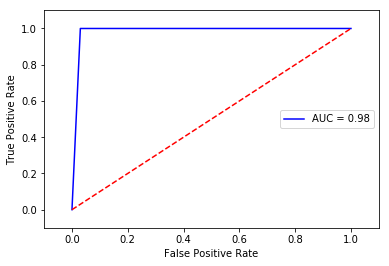

In [47]:
## Prediction and Evaluation
#Test data - Faces
original_pos = [1]*100
calc_predictions(test_pos_img, mu_pos, sig_pos, df_pos, mu_neg, sig_neg, df_neg )

#Test data - Non Faces
original_neg = [0]*100
calc_predictions(test_neg_img, mu_pos, sig_pos, df_pos, mu_neg, sig_neg, df_neg)
original = original_pos + original_neg
probability_pred = calc_accuracy(pred, original)

plot_ROC(original, probability_pred)